In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# from model import Discriminator, Generator, initialize_weights

# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NOISE_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64

transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)


In [8]:
dataset = datasets.MNIST(root = 'data/', train=True, download=False, transform = transform)


# comment mnist above and uncomment below if train on CelebA
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


Epoch [0/5] Batch 0/469                   Loss D: 0.6941, loss G: 0.6950


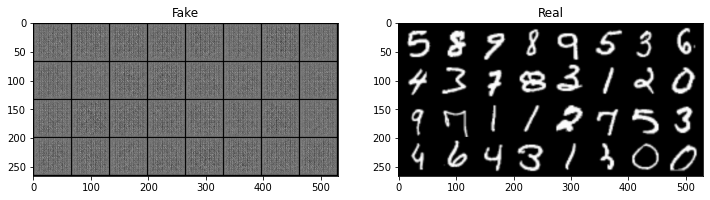

Epoch [0/5] Batch 100/469                   Loss D: 0.0014, loss G: 6.9438


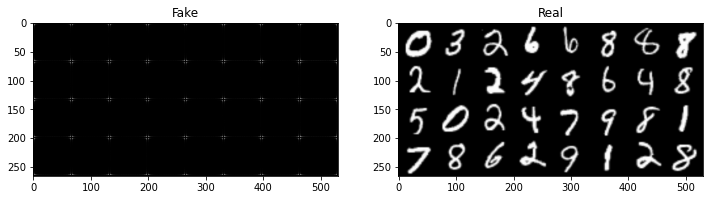

Epoch [0/5] Batch 200/469                   Loss D: 0.0001, loss G: 8.8294


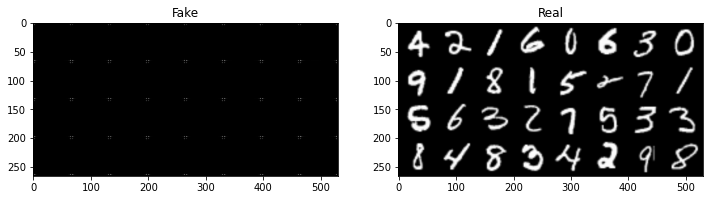

Epoch [0/5] Batch 300/469                   Loss D: 0.0001, loss G: 8.9377


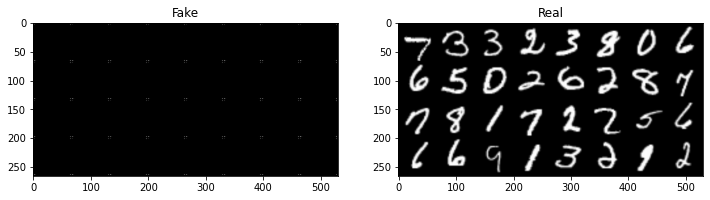

Epoch [0/5] Batch 400/469                   Loss D: 0.0000, loss G: 9.2684


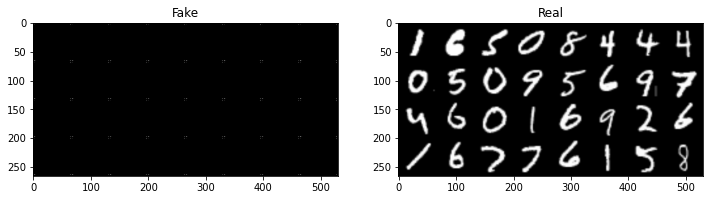

Epoch [1/5] Batch 0/469                   Loss D: 0.0000, loss G: 10.1807


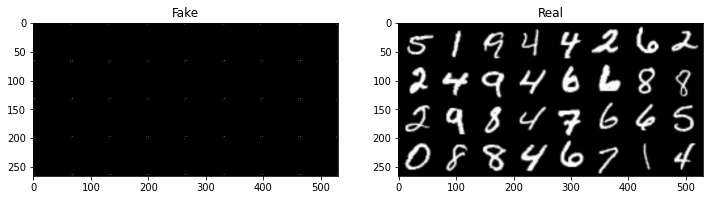

Epoch [1/5] Batch 100/469                   Loss D: 0.0000, loss G: 10.4252


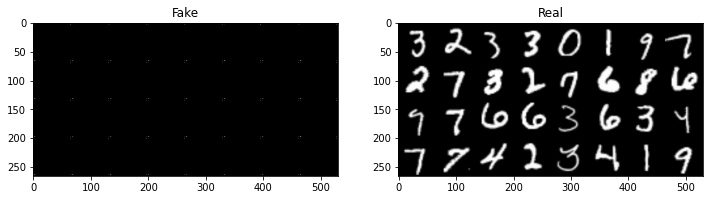

Epoch [1/5] Batch 200/469                   Loss D: 0.0000, loss G: 10.6456


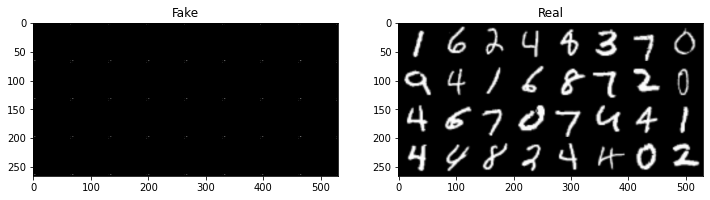

Epoch [1/5] Batch 300/469                   Loss D: 0.0000, loss G: 11.2377


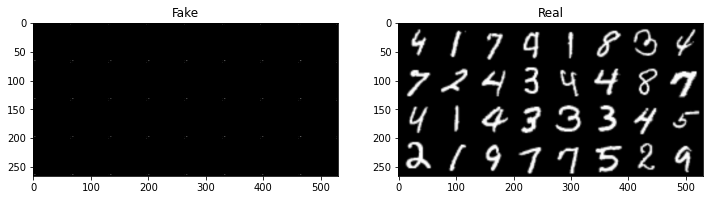

Epoch [1/5] Batch 400/469                   Loss D: 0.0000, loss G: 11.1509


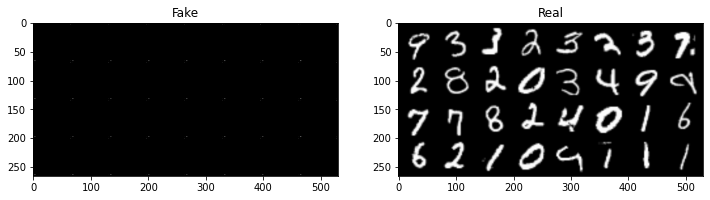

Epoch [2/5] Batch 0/469                   Loss D: 0.0000, loss G: 11.8629


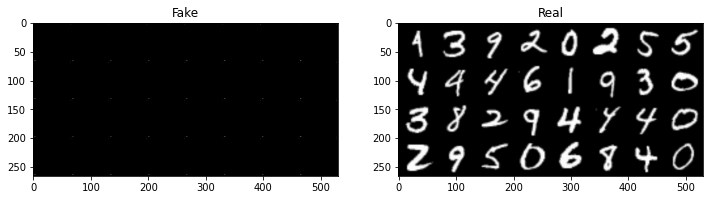

Epoch [2/5] Batch 100/469                   Loss D: 0.0001, loss G: 11.2793


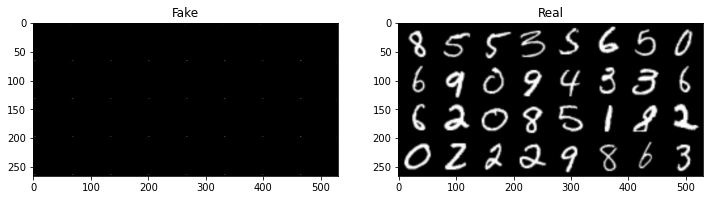

Epoch [2/5] Batch 200/469                   Loss D: 0.0000, loss G: 12.1588


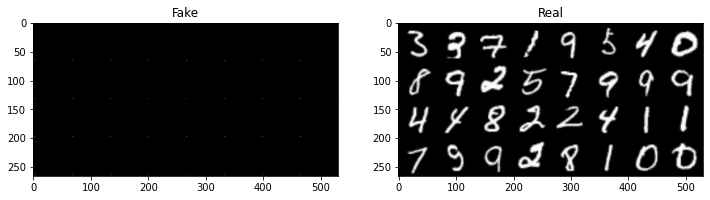

Epoch [2/5] Batch 300/469                   Loss D: 0.0000, loss G: 12.1817


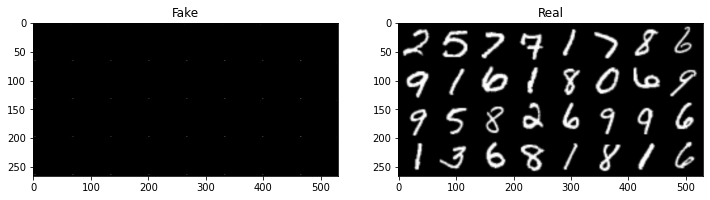

KeyboardInterrupt: 

In [10]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(

            self._block(channels_noise, features_g * 8, 4, 1, 0),  # img: 4x4
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 8x8
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 16x16
            self._block(features_g * 2, features_g , 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g , channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

  
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)

step = 0

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            gen.eval()
            disc.eval()
            print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}")

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    real[:32].cpu().detach(), normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32].cpu().detach(), normalize=True
                )
                
                fig, ax = plt.subplots(1,2, figsize= (12,6))
                ax[0].imshow(img_grid_fake.permute(1, 2, 0))
                ax[1].imshow(img_grid_real.permute(1,2,0))
                ax[0].set_title('Fake')
                ax[1].set_title('Real')

                plt.show()


            step += 1
            gen.train()
            disc.train()